In [1]:
#load predictions
import os
import h5py
import numpy as np
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
import torch


Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to 


In [2]:
predictions_file_1 = os.path.join('/rds/project/kw350',
             'rds-kw350-meld/experiments',
             'co-ripa1/iteration_21-09-15/ensemble_21-09-15',
             'fold_all/results/',
             'predictions_ensemble_iteration.hdf5')

predictions_file_2 = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                       'iteration_21-09-17/ensemble_21-09-20/fold_all/',
                                       'results','predictions_ensemble_iteration.hdf5')

In [3]:
predictions_file = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/22-10-25_real_evaluation/augment_finetune_small/results/predictions.hdf5')

In [4]:
def load_prediction(subject,hdf5):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi]['prediction'][:]
    return results

In [7]:
with h5py.File(predictions_file, "r") as f:
    subjects_new= list(f.keys())
len(subjects_new)



471

In [8]:
with h5py.File(predictions_file_1, "r") as f:
    subjects1 = list(f.keys())
with h5py.File(predictions_file_2, "r") as f:
    subjects2 = list(f.keys())    
    
subjects_old = np.unique(subjects1+subjects2)
subjects_old

array(['MELD2_H7_3T_FCD_001', 'MELD2_H7_3T_FCD_003',
       'MELD2_H7_3T_FCD_004', 'MELD2_H7_3T_FCD_005',
       'MELD2_H7_3T_FCD_006', 'MELD2_H7_3T_FCD_007',
       'MELD2_H7_3T_FCD_008', 'MELD2_H7_3T_FCD_009',
       'MELD2_H7_3T_FCD_010', 'MELD2_H7_3T_FCD_012',
       'MELD2_H7_3T_FCD_013', 'MELD_H10_3T_C_0002', 'MELD_H10_3T_C_0003',
       'MELD_H10_3T_C_0004', 'MELD_H10_3T_C_0005', 'MELD_H10_3T_C_0006',
       'MELD_H10_3T_C_0007', 'MELD_H10_3T_C_0008', 'MELD_H10_3T_C_0009',
       'MELD_H10_3T_C_0010', 'MELD_H10_3T_C_0011', 'MELD_H10_3T_C_0012',
       'MELD_H10_3T_C_0013', 'MELD_H10_3T_C_0014', 'MELD_H10_3T_C_0015',
       'MELD_H10_3T_C_0016', 'MELD_H10_3T_C_0017', 'MELD_H10_3T_C_0018',
       'MELD_H10_3T_C_0019', 'MELD_H10_3T_C_0020', 'MELD_H10_3T_C_0021',
       'MELD_H10_3T_C_0022', 'MELD_H10_3T_C_0023', 'MELD_H10_3T_C_0024',
       'MELD_H10_3T_C_0025', 'MELD_H10_3T_C_0026', 'MELD_H10_3T_C_0027',
       'MELD_H10_3T_C_0028', 'MELD_H10_3T_C_0029', 'MELD_H10_3T_C_0030',
    

In [9]:
subjects = set(subjects_old).intersection(subjects_new)
len(subjects)

453

In [10]:
c = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
               dataset='MELD_dataset_V6.csv')

               


In [11]:
from meld_graph.training import tp_fp_fn_tn, get_sensitivity, dice_coeff

Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1


In [12]:
# small example to test the function
pred = np.array([ 1, 1, 1, 1])
target = np.array([1, 1, 1, 1])

#compute dice with function from training
pred_1= torch.as_tensor(pred).long()
target_1 = torch.as_tensor(target).long()
dices_nonlesion_1, dices_lesion_1 = dice_coeff(torch.nn.functional.one_hot(pred_1, num_classes=2),target_1)

print(dices_lesion_1)
print(dices_nonlesion_1)

tensor(1.)
tensor(1.)


In [90]:
#### compute for multiple threshold with function from training

features=['mathilde']
threshes = [0.2,0.3,0.35,0.4,0.45]
stored_scores=[[],[],[],[],[],[]]

for si,subject in enumerate(subjects):
    print(subject)
    if si%100==0:
        print(si/len(subjects))
        
    results=[]
    try:
        hdf_predictions = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                       'iteration_21-09-15/ensemble_21-09-15/fold_all/',
                                       'results','predictions_ensemble_iteration.hdf5')
        result_hemis = load_prediction(subject,hdf_predictions)
        results.append(result_hemis)
    except KeyError:
        hdf_predictions = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                       'iteration_21-09-17/ensemble_21-09-20/fold_all/',
                                       'results','predictions_ensemble_iteration.hdf5')
        result_hemis = load_prediction(subject,hdf_predictions)
        results.append(result_hemis)
        
    new_result_hemis = load_prediction(subject,predictions_file)
    for t in threshes:
        ti={}
        for hemi in ['lh','rh']:
            ti[hemi]=new_result_hemis[hemi]>t
        
        results.append(ti)
    labels_hemis = {}
    
    subj = MeldSubject(subject,cohort=c)
    detected = False
    stats_stored = np.zeros((len(results),4))
    dices = np.zeros((len(results),2))

    pred={}
    target={}
    
    for ri,r in enumerate(results):
        for hemi in ['lh','rh']:
            _, label = subj.load_feature_lesion_data(
                features, hemi=hemi, features_to_ignore=[])
            
            pred[hemi] = r[hemi].astype('bool')
            target[hemi] = label[c.cortex_mask]
        
        preds = torch.as_tensor(np.array(np.hstack([pred['lh'], pred['rh']]))).long()
        targets = torch.as_tensor(np.array(np.hstack([target['lh'], target['rh']]))).long()
        stats_stored[ri]=tp_fp_fn_tn(targets,preds)
        dices[ri] = dice_coeff(torch.nn.functional.one_hot(preds, num_classes=2),targets)
    
    for ri,r in enumerate(results):
        stored_scores[ri].append([subject,subj.is_patient])
        stored_scores[ri][-1].extend(list(stats_stored[ri]))
        stored_scores[ri][-1].extend(list(dices[ri]))


    

MELD_H21_15T_FCD_0051
0.0
MELD_H18_3T_FCD_0115
MELD_H2_15T_FCD_0008
MELD_H19_3T_C_014
MELD_H19_3T_C_017
MELD_H5_3T_C_0004
MELD_H16_3T_FCD_001
MELD_H3_3T_C_0066


In [88]:
(np.array(stored_scores))

array([[['MELD_H21_15T_FCD_0051', 'True', '4378.0', ..., '181816.0',
         '0.7716459631919861', '0.07524534314870834'],
        ['MELD_H18_3T_FCD_0115', 'True', '1016.0', ..., '290600.0',
         '0.9962494969367981', '0.48151659965515137'],
        ['MELD_H2_15T_FCD_0008', 'True', '0.0', ..., '292206.0',
         '0.9972730875015259', '6.257822442250081e-19'],
        ...,
        ['MELD_H9_3T_FCD_0004', 'True', '556.0', ..., '291424.0',
         '0.996880292892456', '0.3787465989589691'],
        ['MELD_H21_3T_FCD_0030', 'True', '1784.0', ..., '284028.0',
         '0.986126184463501', '0.30865052342414856'],
        ['MELD_H17_3T_FCD_0116', 'True', '5558.0', ..., '276810.0',
         '0.9797613024711609', '0.49290528893470764']],

       [['MELD_H21_15T_FCD_0051', 'True', '85948.0', ..., '102365.0',
         '0.6599488854408264', '0.6196973919868469'],
        ['MELD_H18_3T_FCD_0115', 'True', '2131.0', ..., '225984.0',
         '0.8731032609939575', '0.06092836335301399'],
     

In [66]:
# compute mean dices for cohort
import pandas as pd
import scipy.stats as st

patient_only = (np.array(stored_scores)[0,:,1]=='True')
stored_dices_array = (np.array(stored_scores)[:,patient_only,7]).astype('float').mean(axis=1)
stored_nondices_array = (np.array(stored_scores)[:,:,6]).astype('float').mean(axis=1)

# compute sensitivity and specificity
stored_sensitivity_array = (np.array(stored_scores)[:,patient_only,2].astype('float')>0).sum(axis=1)/patient_only.sum()
stored_specificity_array = (np.array(stored_scores)[:,~patient_only,3].astype('float')==0.0).sum(axis=1)/(~patient_only).sum()

In [ ]:
print(stored_sensitivity_array)
print(stored_specificity_array)



[0.59230769 0.90769231 0.75384615 0.64615385 0.52692308 0.39230769]
[1. 1. 1. 1. 1. 1.]


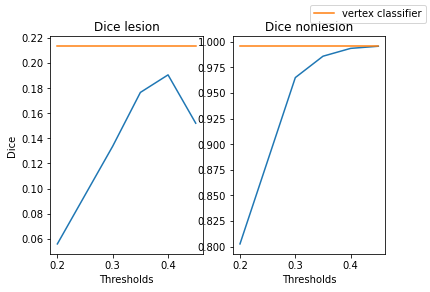

In [58]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2)
ax[0].plot(threshes,stored_dices_array[1:],)
ax[0].plot([threshes[0],threshes[-1]],[stored_dices_array[0],stored_dices_array[0]],label='vertex classifier')
ax[0].set_xlabel('Thresholds')
ax[0].set_ylabel('Dice')

ax[0].set_title("Dice lesion")
#,stored_nondice
ax[1].plot(threshes,stored_nondices_array[1:],)
ax[1].plot([threshes[0],threshes[-1]],[stored_nondices_array[0],stored_nondices_array[0]])
#,stored_nondice
ax[1].set_xlabel('Thresholds')
ax[1].set_title("Dice nonlesion")
fig.legend()

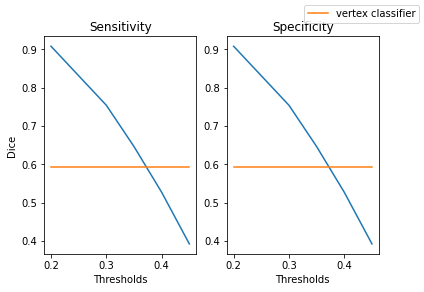

In [59]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2)
ax[0].plot(threshes,stored_sensitivity_array[1:],)
ax[0].plot([threshes[0],threshes[-1]],[stored_sensitivity_array[0],stored_sensitivity_array[0]],label='vertex classifier')
ax[0].set_xlabel('Thresholds')
ax[0].set_ylabel('Dice')

ax[0].set_title("Sensitivity")
#,stored_nondice
ax[1].plot(threshes,stored_sensitivity_array[1:],)
ax[1].plot([threshes[0],threshes[-1]],[stored_sensitivity_array[0],stored_sensitivity_array[0]])
#,stored_nondice
ax[1].set_xlabel('Thresholds')
ax[1].set_title("Specificity")
fig.legend()